In [1]:
## System
import sys
import os
from collections import defaultdict
import gc

## Pandas
import pandas as pd
import numpy as np

## Plotting 
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
con_vs_cass_df_1500bp = pd.read_csv("../data/scored_constitutive_and_cassette_exons.1500bpConSplice.One_over_Prop.txt", sep = "\t", index_col = False, header = 6)

/Users/michaelcormier/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,13,14,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
## Remove exons with missing data
con_vs_cass_df_1500bp = con_vs_cass_df_1500bp.dropna(subset = ["Five_Prime_Interval_Scores","Five_Prime_Exon_start","Exon_Interval_Scores","Three_Prime_Exon_End","Three_Prime_Interval_Scores"])

In [4]:
bins = ["0.0-0.1","0.1-0.2","0.2-0.3","0.3-0.4","0.4-0.5","0.5-0.6","0.6-0.7","0.7-0.8","0.8-0.9","0.9-1.0"]


bin_list = []
for row in con_vs_cass_df_1500bp.itertuples():
    
    for b in bins:
        min_score = float(b.strip().split("-")[0])
        max_score = float(b.strip().split("-")[1])
        
        max_score += 0.1 if max_score == 1.0 else 0.0
        
        if float(row.constitLevel) >= min_score and float(row.constitLevel) < max_score:
            bins_score = b
            break
    bin_list.append(bins_score)
    

    

con_vs_cass_df_1500bp["constitLevel_bin"] = bin_list

In [5]:
new_rows = []
new_header = ["Score","Pos","gene_name", "exon_type","constitLevel","inclLevel", "constitLevel_bin"]

for row in con_vs_cass_df_1500bp.itertuples():
    
    ## Get 5' upstream scores
    for i,score in enumerate(reversed(row.Five_Prime_Interval_Scores.strip().split(","))):
        new_rows.append([float(score), (-25 * (i + 1)), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
    
    ## Get 3' downstream scores
    for j,score in enumerate(row.Three_Prime_Interval_Scores.strip().split(",")):
        new_rows.append([float(score), (125 + (25 * (j + 1))), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
                         
    ## Get 5' exon start 
    new_rows.append([float(row.Five_Prime_Exon_start.strip().split(",")[0]), 0, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
                         
                         
    ## Get 3' exon end 
    new_rows.append([float(row.Three_Prime_Exon_End.strip().split(",")[0]), 125, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin]) 
                         
    ## Get exon scores
    for i,score in enumerate(row.Exon_Interval_Scores.strip().split(",")):
        new_rows.append([float(score), (25 * (i + 1)), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
        

In [6]:
con_vs_cass_1500bp_long_df = pd.DataFrame(new_rows, columns = new_header)

In [7]:
del con_vs_cass_df_1500bp
del new_rows
del new_header
del bin_list
gc.collect()

40

In [8]:
## shift to center plot

### 125 used as offset. 125/2 = recentered 
con_vs_cass_1500bp_long_df["Pos"] = con_vs_cass_1500bp_long_df.Pos - 62.5

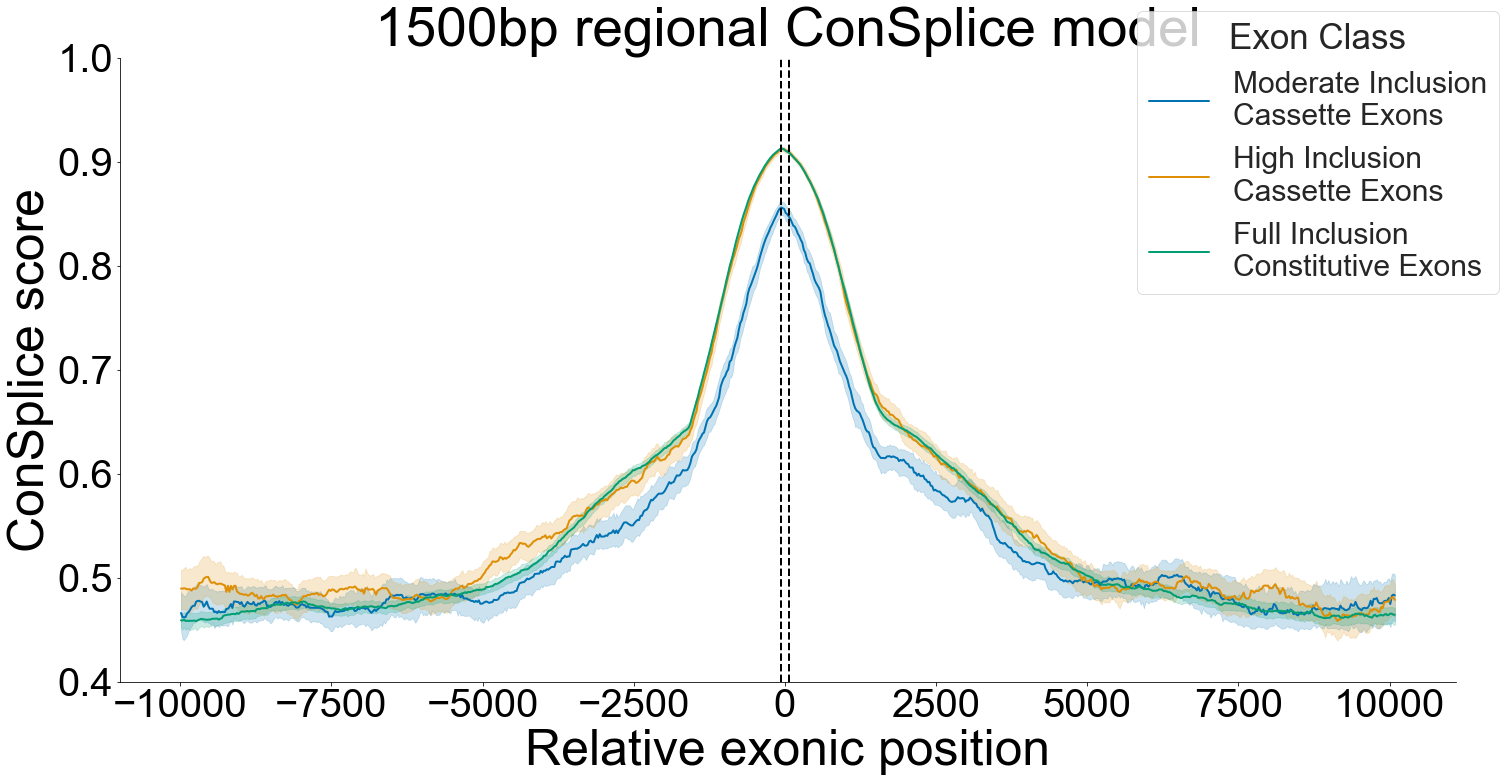

In [9]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (20,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()
fig.tight_layout(pad=2.0)

sns.lineplot(x = "Pos", 
             y = "Score",
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_1500bp_long_df.loc[(con_vs_cass_1500bp_long_df.Pos > -10001) & (con_vs_cass_1500bp_long_df.Pos < 10101) & 
                                            (con_vs_cass_1500bp_long_df.exon_type == "cassette") & 
                                            (con_vs_cass_1500bp_long_df.constitLevel < 0.90) ], 
             label = "Moderate Inclusion\nCassette Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[0],
             ax = ax)

sns.lineplot(x = "Pos", 
             y = "Score",  
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_1500bp_long_df.loc[(con_vs_cass_1500bp_long_df.Pos > -10001) & (con_vs_cass_1500bp_long_df.Pos < 10101) & 
                                            (con_vs_cass_1500bp_long_df.exon_type == "cassette") & 
                                            (con_vs_cass_1500bp_long_df.constitLevel >= 0.90) &(con_vs_cass_1500bp_long_df.constitLevel < 1.0) ], 
             label = "High Inclusion\nCassette Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[1],
             ax = ax)

sns.lineplot(x = "Pos", 
             y = "Score",  
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_1500bp_long_df.loc[(con_vs_cass_1500bp_long_df.Pos > -10001) & (con_vs_cass_1500bp_long_df.Pos < 10101) & 
                                            (con_vs_cass_1500bp_long_df.exon_type == "constitutive") ], 
             label = "Full Inclusion\nConstitutive Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[2],
             ax = ax)


plt.axvline(x = -62.5,ls='--', color = "black", lw = 2)
plt.axvline(x = 62.5,ls='--', color = "black", lw = 2)

ax.set_ylabel("ConSplice score", fontsize = 50)
ax.set_xlabel("Relative exonic position", fontsize = 50)
ax.set_title("1500bp regional ConSplice model", fontsize = 55)

ax.tick_params(axis='x', labelsize=40)
ax.tick_params(axis='y', labelsize=40)

ax.legend(bbox_to_anchor = (0.75,1.1), title = "Exon Class", fontsize = 30, title_fontsize = 35)

plt.ylim(0.4, 1.0)

plt.savefig('../figures/suppl_figure8_B.svg')

In [10]:
con_vs_cass_df_1000bp = pd.read_csv("../data/scored_constitutive_and_cassette_exons.1000bpConSplice.One_over_Prop.txt", sep = "\t", index_col = False, header = 6)

/Users/michaelcormier/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,13,14,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
## Remove exons with missing data
con_vs_cass_df_1000bp = con_vs_cass_df_1000bp.dropna(subset = ["Five_Prime_Interval_Scores","Five_Prime_Exon_start","Exon_Interval_Scores","Three_Prime_Exon_End","Three_Prime_Interval_Scores"])

In [12]:
bins = ["0.0-0.1","0.1-0.2","0.2-0.3","0.3-0.4","0.4-0.5","0.5-0.6","0.6-0.7","0.7-0.8","0.8-0.9","0.9-1.0"]


bin_list = []
for row in con_vs_cass_df_1000bp.itertuples():
    
    for b in bins:
        min_score = float(b.strip().split("-")[0])
        max_score = float(b.strip().split("-")[1])
        
        max_score += 0.1 if max_score == 1.0 else 0.0
        
        if float(row.constitLevel) >= min_score and float(row.constitLevel) < max_score:
            bins_score = b
            break
    bin_list.append(bins_score)
    

    

con_vs_cass_df_1000bp["constitLevel_bin"] = bin_list

In [13]:
new_rows = []
new_header = ["Score","Pos","gene_name", "exon_type","constitLevel","inclLevel", "constitLevel_bin"]

for row in con_vs_cass_df_1000bp.itertuples():
    
    ## Get 5' upstream scores
    for i,score in enumerate(reversed(row.Five_Prime_Interval_Scores.strip().split(","))):
        new_rows.append([float(score), (-25 * (i + 1)), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
    
    ## Get 3' downstream scores
    for j,score in enumerate(row.Three_Prime_Interval_Scores.strip().split(",")):
        new_rows.append([float(score), (125 + (25 * (j + 1))), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
                         
    ## Get 5' exon start 
    new_rows.append([float(row.Five_Prime_Exon_start.strip().split(",")[0]), 0, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
                         
                         
    ## Get 3' exon end 
    new_rows.append([float(row.Three_Prime_Exon_End.strip().split(",")[0]), 125, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin]) 
                         
    ## Get exon scores
    for i,score in enumerate(row.Exon_Interval_Scores.strip().split(",")):
        new_rows.append([float(score), (25 * (i + 1)), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
        

In [14]:
con_vs_cass_1000bp_long_df = pd.DataFrame(new_rows, columns = new_header)

In [15]:
del con_vs_cass_df_1000bp
del new_rows
del new_header
del bin_list
gc.collect()

40

In [16]:
## shift to center plot

### 125 used as offset. 125/2 = recentered 
con_vs_cass_1000bp_long_df["Pos"] = con_vs_cass_1000bp_long_df.Pos - 62.5

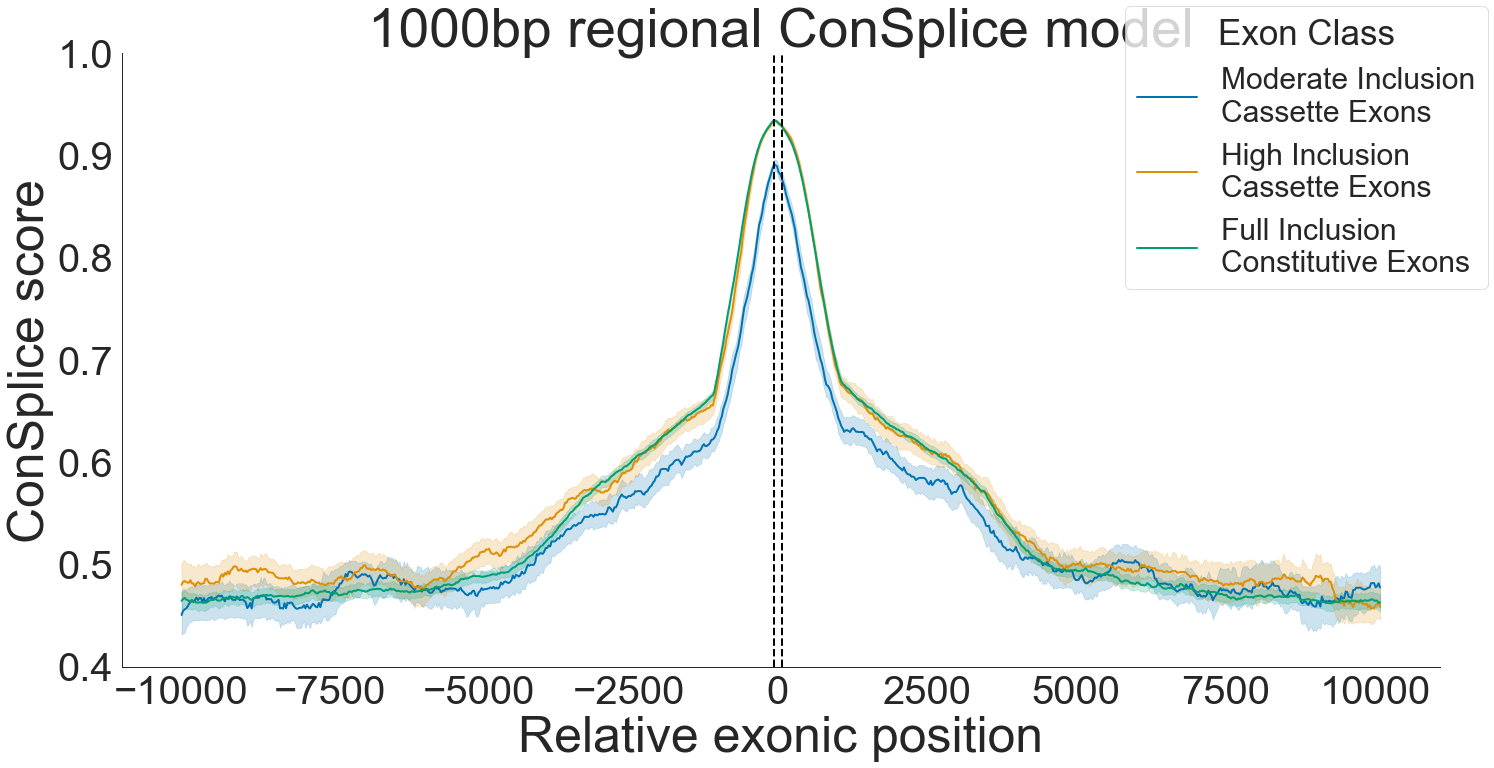

In [17]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (20,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()
fig.tight_layout(pad=2.0)

sns.lineplot(x = "Pos", 
             y = "Score",
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_1000bp_long_df.loc[(con_vs_cass_1000bp_long_df.Pos > -10001) & (con_vs_cass_1000bp_long_df.Pos < 10101) & 
                                            (con_vs_cass_1000bp_long_df.exon_type == "cassette") & 
                                            (con_vs_cass_1000bp_long_df.constitLevel < 0.90) ], 
             label = "Moderate Inclusion\nCassette Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[0],
             ax = ax)

sns.lineplot(x = "Pos", 
             y = "Score",  
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_1000bp_long_df.loc[(con_vs_cass_1000bp_long_df.Pos > -10001) & (con_vs_cass_1000bp_long_df.Pos < 10101) & 
                                            (con_vs_cass_1000bp_long_df.exon_type == "cassette") & 
                                            (con_vs_cass_1000bp_long_df.constitLevel >= 0.90) &(con_vs_cass_1000bp_long_df.constitLevel < 1.0) ], 
             label = "High Inclusion\nCassette Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[1],
             ax = ax)

sns.lineplot(x = "Pos", 
             y = "Score",  
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_1000bp_long_df.loc[(con_vs_cass_1000bp_long_df.Pos > -10001) & (con_vs_cass_1000bp_long_df.Pos < 10101) & 
                                            (con_vs_cass_1000bp_long_df.exon_type == "constitutive") ], 
             label = "Full Inclusion\nConstitutive Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[2],
             ax = ax)


plt.axvline(x = -62.5,ls='--', color = "black", lw = 2)
plt.axvline(x = 62.5,ls='--', color = "black", lw = 2)

ax.set_ylabel("ConSplice score", fontsize = 50)
ax.set_xlabel("Relative exonic position", fontsize = 50)
ax.set_title("1000bp regional ConSplice model", fontsize = 55)

ax.tick_params(axis='x', labelsize=40)
ax.tick_params(axis='y', labelsize=40)

ax.legend(bbox_to_anchor = (0.75,1.1), title = "Exon Class", fontsize = 30, title_fontsize = 35)

plt.ylim(0.4, 1.0)

plt.savefig('../figures/suppl_figure8_C.svg')

In [18]:
con_vs_cass_df_800bp = pd.read_csv("../data/scored_constitutive_and_cassette_exons.800bpConSplice.One_over_Prop.txt", sep = "\t", index_col = False, header = 6)

/Users/michaelcormier/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,13,14,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
## Remove exons with missing data
con_vs_cass_df_800bp = con_vs_cass_df_800bp.dropna(subset = ["Five_Prime_Interval_Scores","Five_Prime_Exon_start","Exon_Interval_Scores","Three_Prime_Exon_End","Three_Prime_Interval_Scores"])

In [20]:
bins = ["0.0-0.1","0.1-0.2","0.2-0.3","0.3-0.4","0.4-0.5","0.5-0.6","0.6-0.7","0.7-0.8","0.8-0.9","0.9-1.0"]


bin_list = []
for row in con_vs_cass_df_800bp.itertuples():
    
    for b in bins:
        min_score = float(b.strip().split("-")[0])
        max_score = float(b.strip().split("-")[1])
        
        max_score += 0.1 if max_score == 1.0 else 0.0
        
        if float(row.constitLevel) >= min_score and float(row.constitLevel) < max_score:
            bins_score = b
            break
    bin_list.append(bins_score)
    

    

con_vs_cass_df_800bp["constitLevel_bin"] = bin_list

In [21]:
new_rows = []
new_header = ["Score","Pos","gene_name", "exon_type","constitLevel","inclLevel", "constitLevel_bin"]

for row in con_vs_cass_df_800bp.itertuples():
    
    ## Get 5' upstream scores
    for i,score in enumerate(reversed(row.Five_Prime_Interval_Scores.strip().split(","))):
        new_rows.append([float(score), (-25 * (i + 1)), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
    
    ## Get 3' downstream scores
    for j,score in enumerate(row.Three_Prime_Interval_Scores.strip().split(",")):
        new_rows.append([float(score), (125 + (25 * (j + 1))), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
                         
    ## Get 5' exon start 
    new_rows.append([float(row.Five_Prime_Exon_start.strip().split(",")[0]), 0, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
                         
                         
    ## Get 3' exon end 
    new_rows.append([float(row.Three_Prime_Exon_End.strip().split(",")[0]), 125, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin]) 
                         
    ## Get exon scores
    for i,score in enumerate(row.Exon_Interval_Scores.strip().split(",")):
        new_rows.append([float(score), (25 * (i + 1)), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
        

In [22]:
con_vs_cass_800bp_long_df = pd.DataFrame(new_rows, columns = new_header)

In [23]:
del con_vs_cass_df_800bp
del new_rows
del new_header
del bin_list
gc.collect()

40

In [24]:
## shift to center plot

### 125 used as offset. 125/2 = recentered 
con_vs_cass_800bp_long_df["Pos"] = con_vs_cass_800bp_long_df.Pos - 62.5

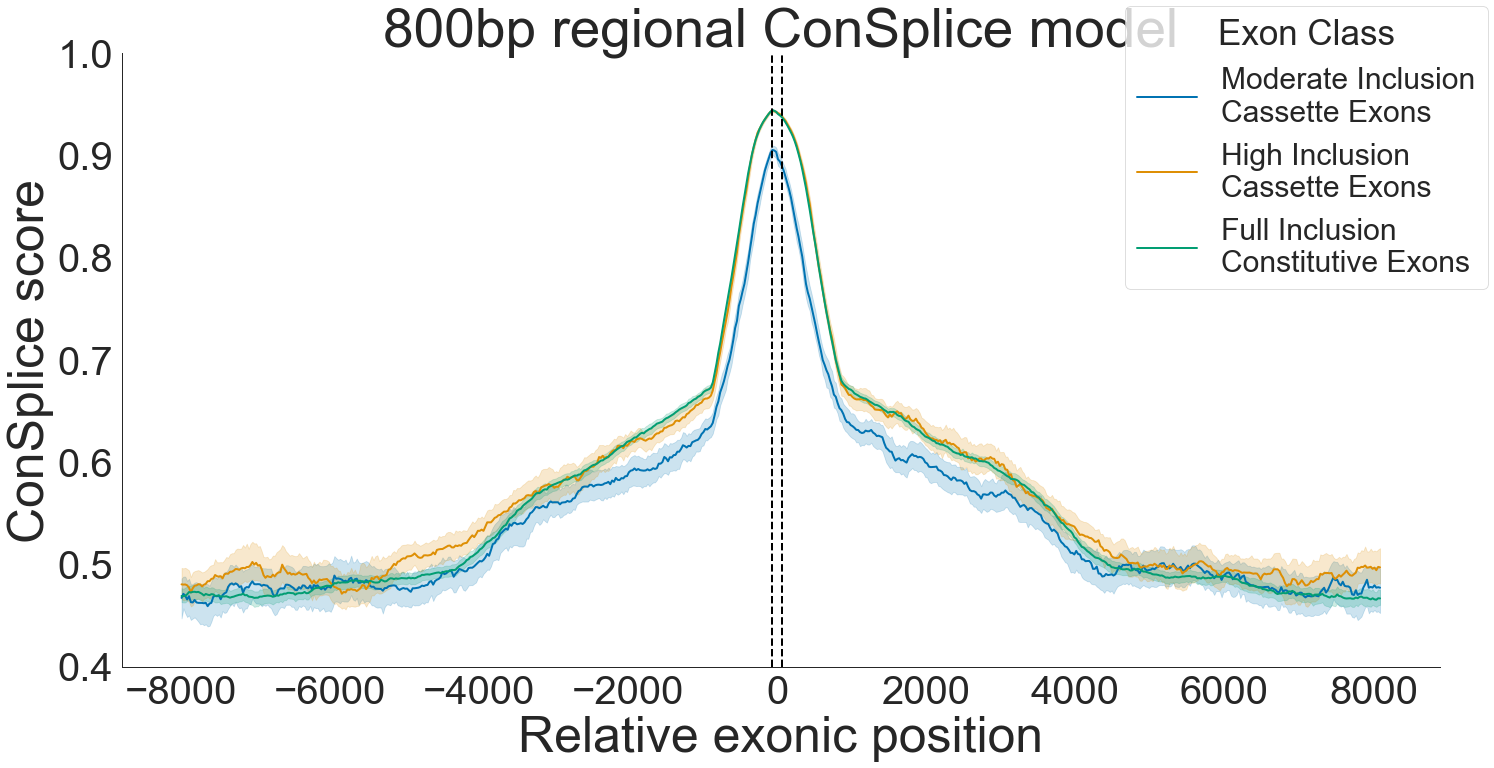

In [25]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (20,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()
fig.tight_layout(pad=2.0)

sns.lineplot(x = "Pos", 
             y = "Score",
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_800bp_long_df.loc[(con_vs_cass_800bp_long_df.Pos > -8001) & (con_vs_cass_800bp_long_df.Pos < 8101) & 
                                            (con_vs_cass_800bp_long_df.exon_type == "cassette") & 
                                            (con_vs_cass_800bp_long_df.constitLevel < 0.90) ], 
             label = "Moderate Inclusion\nCassette Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[0],
             ax = ax)

sns.lineplot(x = "Pos", 
             y = "Score",  
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_800bp_long_df.loc[(con_vs_cass_800bp_long_df.Pos > -8001) & (con_vs_cass_800bp_long_df.Pos < 8101) & 
                                            (con_vs_cass_800bp_long_df.exon_type == "cassette") & 
                                            (con_vs_cass_800bp_long_df.constitLevel >= 0.90) &(con_vs_cass_800bp_long_df.constitLevel < 1.0) ], 
             label = "High Inclusion\nCassette Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[1],
             ax = ax)

sns.lineplot(x = "Pos", 
             y = "Score",  
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_800bp_long_df.loc[(con_vs_cass_800bp_long_df.Pos > -8001) & (con_vs_cass_800bp_long_df.Pos < 8101) & 
                                            (con_vs_cass_800bp_long_df.exon_type == "constitutive") ], 
             label = "Full Inclusion\nConstitutive Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[2],
             ax = ax)


plt.axvline(x = -62.5,ls='--', color = "black", lw = 2)
plt.axvline(x = 62.5,ls='--', color = "black", lw = 2)

ax.set_ylabel("ConSplice score", fontsize = 50)
ax.set_xlabel("Relative exonic position", fontsize = 50)
ax.set_title("800bp regional ConSplice model", fontsize = 55)

ax.tick_params(axis='x', labelsize=40)
ax.tick_params(axis='y', labelsize=40)

ax.legend(bbox_to_anchor = (0.75,1.1), title = "Exon Class", fontsize = 30, title_fontsize = 35)

plt.ylim(0.4, 1.0)

plt.savefig('../figures/suppl_figure8_D.svg')

In [26]:
con_vs_cass_df_400bp = pd.read_csv("../data/scored_constitutive_and_cassette_exons.400bpConSplice.One_over_Prop.txt", sep = "\t", index_col = False, header = 6)

/Users/michaelcormier/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,13,14,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
## Remove exons with missing data
con_vs_cass_df_400bp = con_vs_cass_df_400bp.dropna(subset = ["Five_Prime_Interval_Scores","Five_Prime_Exon_start","Exon_Interval_Scores","Three_Prime_Exon_End","Three_Prime_Interval_Scores"])

In [28]:
bins = ["0.0-0.1","0.1-0.2","0.2-0.3","0.3-0.4","0.4-0.5","0.5-0.6","0.6-0.7","0.7-0.8","0.8-0.9","0.9-1.0"]


bin_list = []
for row in con_vs_cass_df_400bp.itertuples():
    
    for b in bins:
        min_score = float(b.strip().split("-")[0])
        max_score = float(b.strip().split("-")[1])
        
        max_score += 0.1 if max_score == 1.0 else 0.0
        
        if float(row.constitLevel) >= min_score and float(row.constitLevel) < max_score:
            bins_score = b
            break
    bin_list.append(bins_score)
    

    

con_vs_cass_df_400bp["constitLevel_bin"] = bin_list

In [29]:
new_rows = []
new_header = ["Score","Pos","gene_name", "exon_type","constitLevel","inclLevel", "constitLevel_bin"]

for row in con_vs_cass_df_400bp.itertuples():
    
    ## Get 5' upstream scores
    for i,score in enumerate(reversed(row.Five_Prime_Interval_Scores.strip().split(","))):
        new_rows.append([float(score), (-25 * (i + 1)), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
    
    ## Get 3' downstream scores
    for j,score in enumerate(row.Three_Prime_Interval_Scores.strip().split(",")):
        new_rows.append([float(score), (125 + (25 * (j + 1))), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
                         
    ## Get 5' exon start 
    if isinstance(row.Five_Prime_Exon_start, str):
        new_rows.append([float(row.Five_Prime_Exon_start.strip().split(",")[0]), 0, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
    else:
        new_rows.append([float(row.Five_Prime_Exon_start), 0, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
         
                         
    ## Get 3' exon end 
    if isinstance(row.Three_Prime_Exon_End, str):
        new_rows.append([float(row.Three_Prime_Exon_End.strip().split(",")[0]), 125, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin]) 
    else:
        new_rows.append([float(row.Three_Prime_Exon_End), 125, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin]) 
    
    ## Get exon scores
    for i,score in enumerate(row.Exon_Interval_Scores.strip().split(",")):
        new_rows.append([float(score), (25 * (i + 1)), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
        

In [30]:
con_vs_cass_400bp_long_df = pd.DataFrame(new_rows, columns = new_header)

In [31]:
del con_vs_cass_df_400bp
del new_rows
del new_header
del bin_list
gc.collect()

40

In [32]:
## shift to center plot

### 125 used as offset. 125/2 = recentered 
con_vs_cass_400bp_long_df["Pos"] = con_vs_cass_400bp_long_df.Pos - 62.5

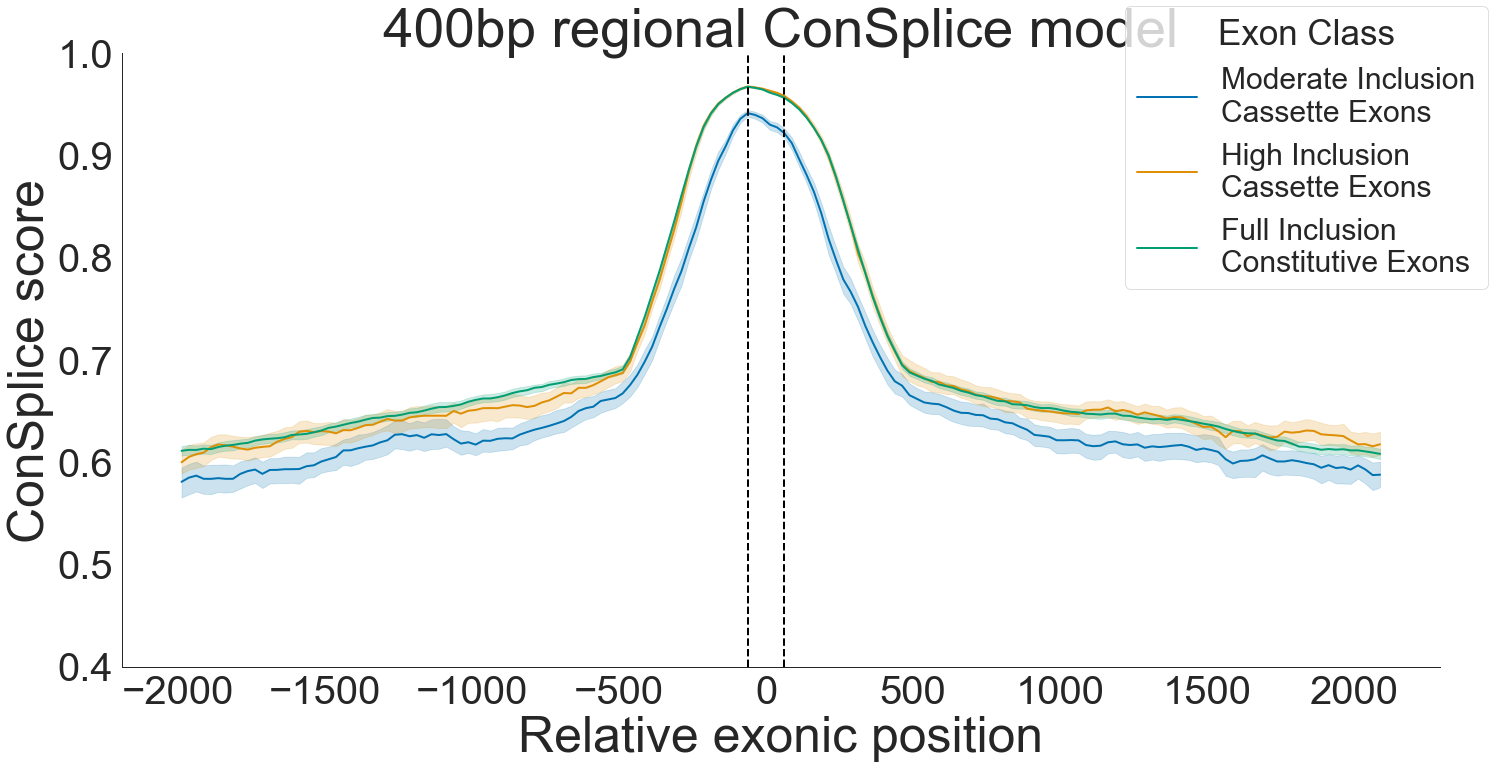

In [33]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (20,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()
fig.tight_layout(pad=2.0)

sns.lineplot(x = "Pos", 
             y = "Score",
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_400bp_long_df.loc[(con_vs_cass_400bp_long_df.Pos > -2001) & (con_vs_cass_400bp_long_df.Pos < 2101) & 
                                            (con_vs_cass_400bp_long_df.exon_type == "cassette") & 
                                            (con_vs_cass_400bp_long_df.constitLevel < 0.90) ], 
             label = "Moderate Inclusion\nCassette Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[0],
             ax = ax)

sns.lineplot(x = "Pos", 
             y = "Score",  
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_400bp_long_df.loc[(con_vs_cass_400bp_long_df.Pos > -2001) & (con_vs_cass_400bp_long_df.Pos < 2101) & 
                                            (con_vs_cass_400bp_long_df.exon_type == "cassette") & 
                                            (con_vs_cass_400bp_long_df.constitLevel >= 0.90) &(con_vs_cass_400bp_long_df.constitLevel < 1.0) ], 
             label = "High Inclusion\nCassette Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[1],
             ax = ax)

sns.lineplot(x = "Pos", 
             y = "Score",  
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_400bp_long_df.loc[(con_vs_cass_400bp_long_df.Pos > -2001) & (con_vs_cass_400bp_long_df.Pos < 2101) & 
                                            (con_vs_cass_400bp_long_df.exon_type == "constitutive") ], 
             label = "Full Inclusion\nConstitutive Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[2],
             ax = ax)


plt.axvline(x = -62.5,ls='--', color = "black", lw = 2)
plt.axvline(x = 62.5,ls='--', color = "black", lw = 2)

ax.set_ylabel("ConSplice score", fontsize = 50)
ax.set_xlabel("Relative exonic position", fontsize = 50)
ax.set_title("400bp regional ConSplice model", fontsize = 55)

ax.tick_params(axis='x', labelsize=40)
ax.tick_params(axis='y', labelsize=40)

ax.legend(bbox_to_anchor = (0.75,1.1), title = "Exon Class", fontsize = 30, title_fontsize = 35)

plt.ylim(0.4, 1.0)

plt.savefig('../figures/suppl_figure8_F.svg')

In [34]:
con_vs_cass_df_200bp = pd.read_csv("../data/scored_constitutive_and_cassette_exons.200bpConSplice.One_over_Prop.txt", sep = "\t", index_col = False, header = 6)

/Users/michaelcormier/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,13,14,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [35]:
## Remove exons with missing data
con_vs_cass_df_200bp = con_vs_cass_df_200bp.dropna(subset = ["Five_Prime_Interval_Scores","Five_Prime_Exon_start","Exon_Interval_Scores","Three_Prime_Exon_End","Three_Prime_Interval_Scores"])

In [36]:
bins = ["0.0-0.1","0.1-0.2","0.2-0.3","0.3-0.4","0.4-0.5","0.5-0.6","0.6-0.7","0.7-0.8","0.8-0.9","0.9-1.0"]


bin_list = []
for row in con_vs_cass_df_200bp.itertuples():
    
    for b in bins:
        min_score = float(b.strip().split("-")[0])
        max_score = float(b.strip().split("-")[1])
        
        max_score += 0.1 if max_score == 1.0 else 0.0
        
        if float(row.constitLevel) >= min_score and float(row.constitLevel) < max_score:
            bins_score = b
            break
    bin_list.append(bins_score)
    

    

con_vs_cass_df_200bp["constitLevel_bin"] = bin_list

In [37]:
new_rows = []
new_header = ["Score","Pos","gene_name", "exon_type","constitLevel","inclLevel", "constitLevel_bin"]

for row in con_vs_cass_df_200bp.itertuples():
    
    ## Get 5' upstream scores
    for i,score in enumerate(reversed(row.Five_Prime_Interval_Scores.strip().split(","))):
        new_rows.append([float(score), (-25 * (i + 1)), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
    
    ## Get 3' downstream scores
    for j,score in enumerate(row.Three_Prime_Interval_Scores.strip().split(",")):
        new_rows.append([float(score), (125 + (25 * (j + 1))), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
                         
    ## Get 5' exon start 
    if isinstance(row.Five_Prime_Exon_start, str):
        new_rows.append([float(row.Five_Prime_Exon_start.strip().split(",")[0]), 0, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
    else:
        new_rows.append([float(row.Five_Prime_Exon_start), 0, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
         
                         
    ## Get 3' exon end 
    if isinstance(row.Three_Prime_Exon_End, str):
        new_rows.append([float(row.Three_Prime_Exon_End.strip().split(",")[0]), 125, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin]) 
    else:
        new_rows.append([float(row.Three_Prime_Exon_End), 125, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin]) 
    
    ## Get exon scores
    for i,score in enumerate(row.Exon_Interval_Scores.strip().split(",")):
        new_rows.append([float(score), (25 * (i + 1)), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
        

In [38]:
con_vs_cass_200bp_long_df = pd.DataFrame(new_rows, columns = new_header)

In [39]:
del con_vs_cass_df_200bp
del new_rows
del new_header
del bin_list
gc.collect()

40

In [40]:
## shift to center plot

### 125 used as offset. 125/2 = recentered 
con_vs_cass_200bp_long_df["Pos"] = con_vs_cass_200bp_long_df.Pos - 62.5

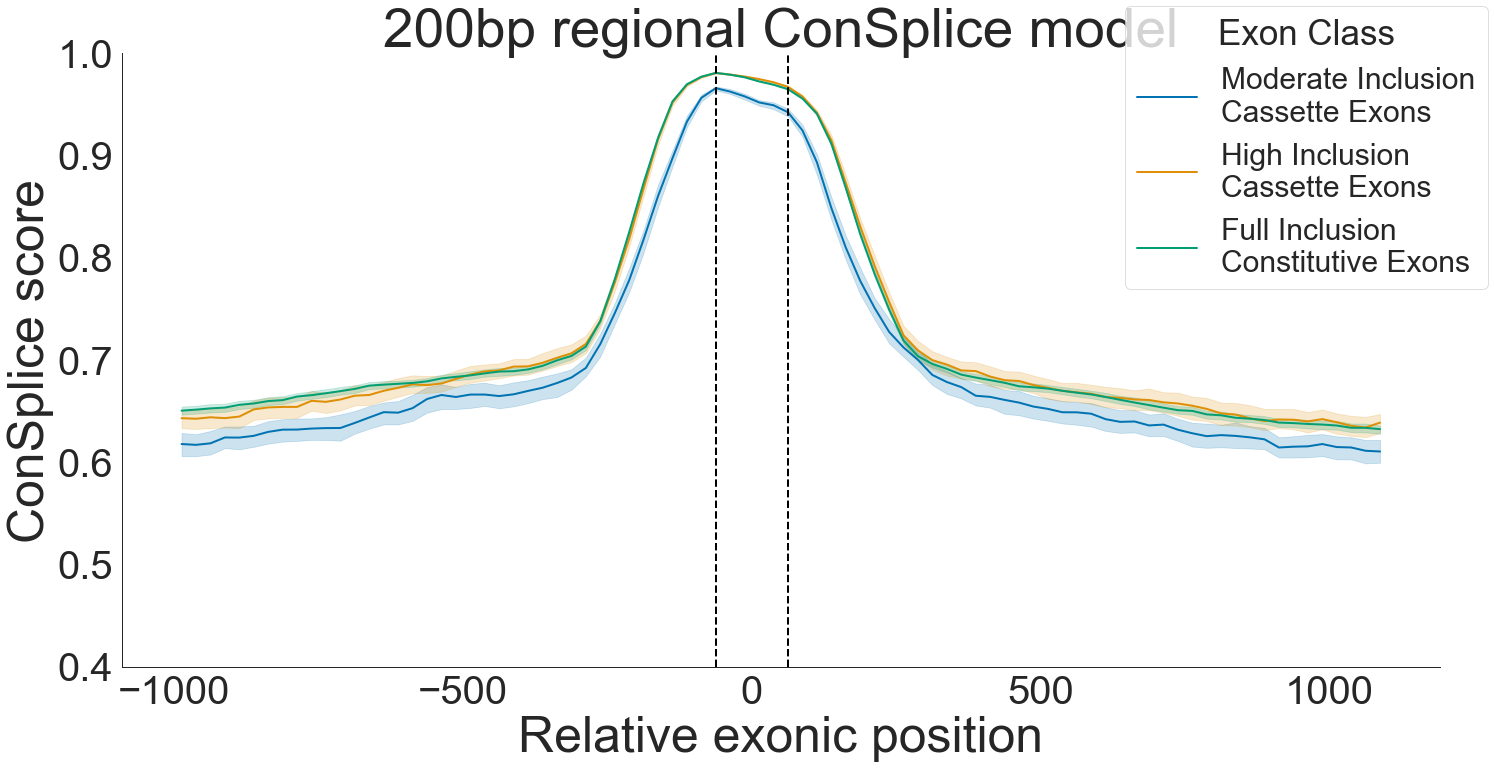

In [41]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (20,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()
fig.tight_layout(pad=2.0)

sns.lineplot(x = "Pos", 
             y = "Score",
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_200bp_long_df.loc[(con_vs_cass_200bp_long_df.Pos > -1001) & (con_vs_cass_200bp_long_df.Pos < 1101) & 
                                            (con_vs_cass_200bp_long_df.exon_type == "cassette") & 
                                            (con_vs_cass_200bp_long_df.constitLevel < 0.90) ], 
             label = "Moderate Inclusion\nCassette Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[0],
             ax = ax)

sns.lineplot(x = "Pos", 
             y = "Score",  
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_200bp_long_df.loc[(con_vs_cass_200bp_long_df.Pos > -1001) & (con_vs_cass_200bp_long_df.Pos < 1101) & 
                                            (con_vs_cass_200bp_long_df.exon_type == "cassette") & 
                                            (con_vs_cass_200bp_long_df.constitLevel >= 0.90) &(con_vs_cass_200bp_long_df.constitLevel < 1.0) ], 
             label = "High Inclusion\nCassette Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[1],
             ax = ax)

sns.lineplot(x = "Pos", 
             y = "Score",  
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_200bp_long_df.loc[(con_vs_cass_200bp_long_df.Pos > -1001) & (con_vs_cass_200bp_long_df.Pos < 1101) & 
                                            (con_vs_cass_200bp_long_df.exon_type == "constitutive") ], 
             label = "Full Inclusion\nConstitutive Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[2],
             ax = ax)


plt.axvline(x = -62.5,ls='--', color = "black", lw = 2)
plt.axvline(x = 62.5,ls='--', color = "black", lw = 2)

ax.set_ylabel("ConSplice score", fontsize = 50)
ax.set_xlabel("Relative exonic position", fontsize = 50)
ax.set_title("200bp regional ConSplice model", fontsize = 55)

ax.tick_params(axis='x', labelsize=40)
ax.tick_params(axis='y', labelsize=40)

ax.legend(bbox_to_anchor = (0.75,1.1), title = "Exon Class", fontsize = 30, title_fontsize = 35)

plt.ylim(0.4, 1.0)

plt.savefig('../figures/suppl_figure8_G.svg')

In [42]:
con_vs_cass_df_100bp = pd.read_csv("../data/scored_constitutive_and_cassette_exons.100bpConSplice.One_over_Prop.txt", sep = "\t", index_col = False, header = 6)

/Users/michaelcormier/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,13,14,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [43]:
## Remove exons with missing data
con_vs_cass_df_100bp = con_vs_cass_df_100bp.dropna(subset = ["Five_Prime_Interval_Scores","Five_Prime_Exon_start","Exon_Interval_Scores","Three_Prime_Exon_End","Three_Prime_Interval_Scores"])

In [44]:
bins = ["0.0-0.1","0.1-0.2","0.2-0.3","0.3-0.4","0.4-0.5","0.5-0.6","0.6-0.7","0.7-0.8","0.8-0.9","0.9-1.0"]


bin_list = []
for row in con_vs_cass_df_100bp.itertuples():
    
    for b in bins:
        min_score = float(b.strip().split("-")[0])
        max_score = float(b.strip().split("-")[1])
        
        max_score += 0.1 if max_score == 1.0 else 0.0
        
        if float(row.constitLevel) >= min_score and float(row.constitLevel) < max_score:
            bins_score = b
            break
    bin_list.append(bins_score)
    

    

con_vs_cass_df_100bp["constitLevel_bin"] = bin_list

In [45]:
new_rows = []
new_header = ["Score","Pos","gene_name", "exon_type","constitLevel","inclLevel", "constitLevel_bin"]

for row in con_vs_cass_df_100bp.itertuples():
    
    ## Get 5' upstream scores
    for i,score in enumerate(reversed(row.Five_Prime_Interval_Scores.strip().split(","))):
        new_rows.append([float(score), (-25 * (i + 1)), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
    
    ## Get 3' downstream scores
    for j,score in enumerate(row.Three_Prime_Interval_Scores.strip().split(",")):
        new_rows.append([float(score), (125 + (25 * (j + 1))), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
                         
    ## Get 5' exon start 
    if isinstance(row.Five_Prime_Exon_start, str):
        new_rows.append([float(row.Five_Prime_Exon_start.strip().split(",")[0]), 0, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
    else:
        new_rows.append([float(row.Five_Prime_Exon_start), 0, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
         
                         
    ## Get 3' exon end 
    if isinstance(row.Three_Prime_Exon_End, str):
        new_rows.append([float(row.Three_Prime_Exon_End.strip().split(",")[0]), 125, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin]) 
    else:
        new_rows.append([float(row.Three_Prime_Exon_End), 125, row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin]) 
                        
    ## Get exon scores
    for i,score in enumerate(row.Exon_Interval_Scores.strip().split(",")):
        new_rows.append([float(score), (25 * (i + 1)), row.gene_name, row.exon_type, row.constitLevel, row.inclLevel, row.constitLevel_bin])
        

In [46]:
con_vs_cass_100bp_long_df = pd.DataFrame(new_rows, columns = new_header)

In [47]:
del con_vs_cass_df_100bp
del new_rows
del new_header
del bin_list
gc.collect()

40

In [48]:
## shift to center plot

### 125 used as offset. 125/2 = recentered 
con_vs_cass_100bp_long_df["Pos"] = con_vs_cass_100bp_long_df.Pos - 62.5

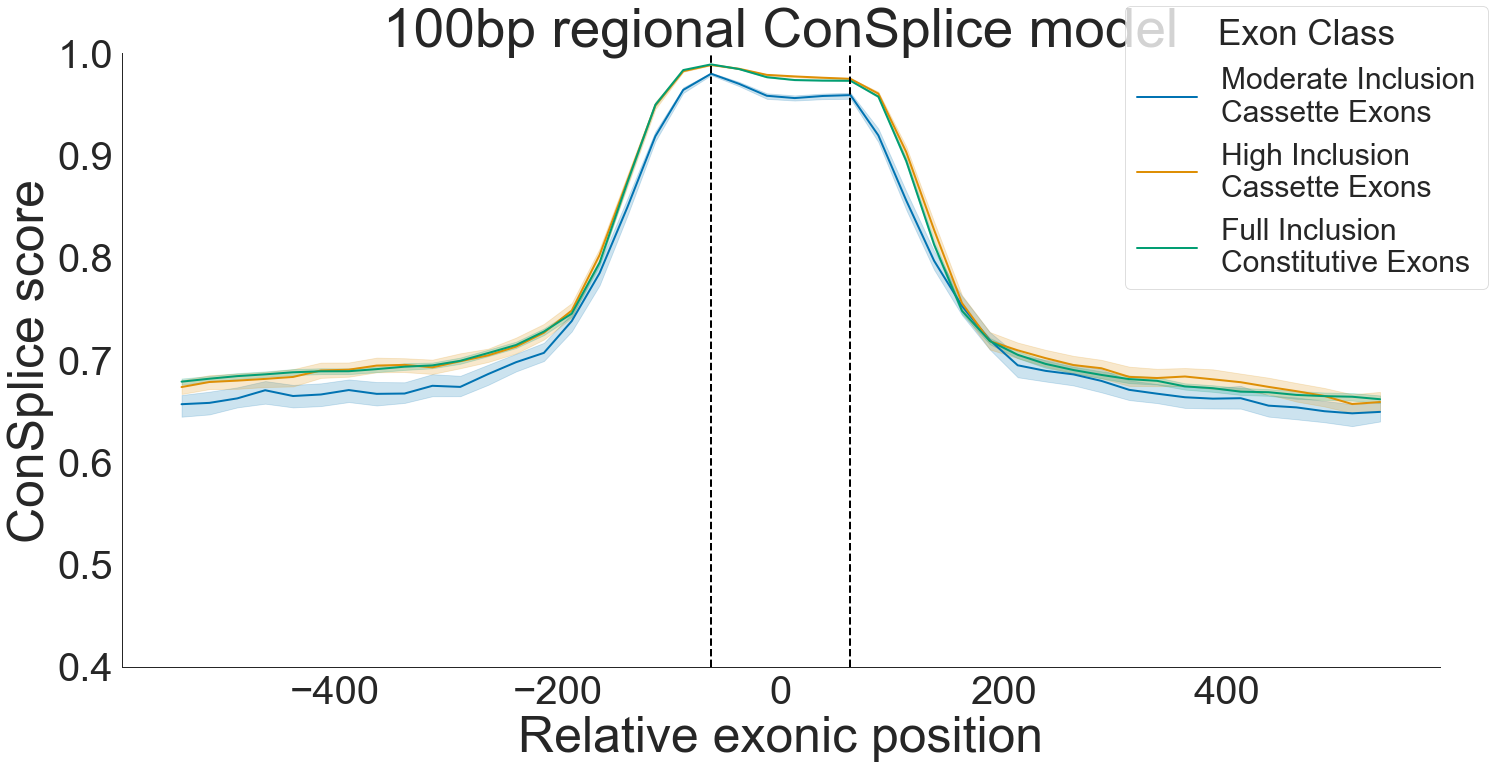

In [49]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (20,10))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()
fig.tight_layout(pad=2.0)

sns.lineplot(x = "Pos", 
             y = "Score",
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_100bp_long_df.loc[(con_vs_cass_100bp_long_df.Pos > -561) & (con_vs_cass_100bp_long_df.Pos < 561) & 
                                            (con_vs_cass_100bp_long_df.exon_type == "cassette") & 
                                            (con_vs_cass_100bp_long_df.constitLevel < 0.90) ], 
             label = "Moderate Inclusion\nCassette Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[0],
             ax = ax)

sns.lineplot(x = "Pos", 
             y = "Score",  
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_100bp_long_df.loc[(con_vs_cass_100bp_long_df.Pos > -561) & (con_vs_cass_100bp_long_df.Pos < 561) & 
                                            (con_vs_cass_100bp_long_df.exon_type == "cassette") & 
                                            (con_vs_cass_100bp_long_df.constitLevel >= 0.90) &(con_vs_cass_100bp_long_df.constitLevel < 1.0) ], 
             label = "High Inclusion\nCassette Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[1],
             ax = ax)

sns.lineplot(x = "Pos", 
             y = "Score",  
             ci=95, 
             estimator=np.median,
             n_boot=1000,
             data = con_vs_cass_100bp_long_df.loc[(con_vs_cass_100bp_long_df.Pos > -561) & (con_vs_cass_100bp_long_df.Pos < 561) & 
                                            (con_vs_cass_100bp_long_df.exon_type == "constitutive") ], 
             label = "Full Inclusion\nConstitutive Exons", 
             linewidth = 2,
             color = sns.color_palette("colorblind")[2],
             ax = ax)


plt.axvline(x = -62.5,ls='--', color = "black", lw = 2)
plt.axvline(x = 62.5,ls='--', color = "black", lw = 2)

ax.set_ylabel("ConSplice score", fontsize = 50)
ax.set_xlabel("Relative exonic position", fontsize = 50)
ax.set_title("100bp regional ConSplice model", fontsize = 55)

ax.tick_params(axis='x', labelsize=40)
ax.tick_params(axis='y', labelsize=40)

ax.legend(bbox_to_anchor = (0.75,1.1), title = "Exon Class", fontsize = 30, title_fontsize = 35)

plt.ylim(0.4, 1.0)

plt.savefig('../figures/suppl_figure8_H.svg')